<a href="https://colab.research.google.com/github/PravallikaSomisetti/CODSOFT/blob/main/sales_prediction_codsoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error: Dataset file 'sales_data.csv' not found.
Please make sure the CSV file is in the same directory as this script, or provide the full path.
Creating a dummy 'sales_data.csv' for demonstration purposes.
Dummy file 'sales_data.csv' created. Please replace it with your actual data.
Successfully loaded data from 'sales_data.csv'.
Data preprocessed successfully for Prophet.
Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzjqsfa1b/wtdgiel5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzjqsfa1b/xz1_q51t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65717', 'data', 'file=/tmp/tmpzjqsfa1b/wtdgiel5.json', 'init=/tmp/tmpzjqsfa1b/xz1_q51t.json', 'output', 'file=/tmp/tmpzjqsfa1b/prophet_modelrjxebk7n/prophet_model-20250722025252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:52:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model training complete.
Generating future dataframe for 30 days...
Making predictions...
Predictions generated.
Evaluating model performance...
Mean Absolute Error (MAE): 87.44
Root Mean Squared Error (RMSE): 102.17
Mean Absolute Percentage Error (MAPE): 25.55%
Generating visualizations...


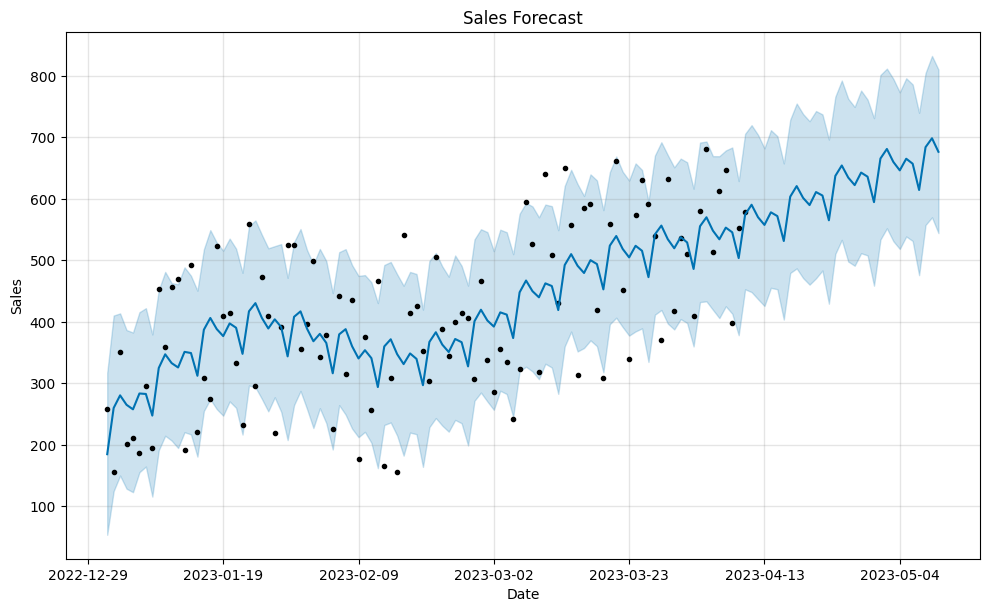

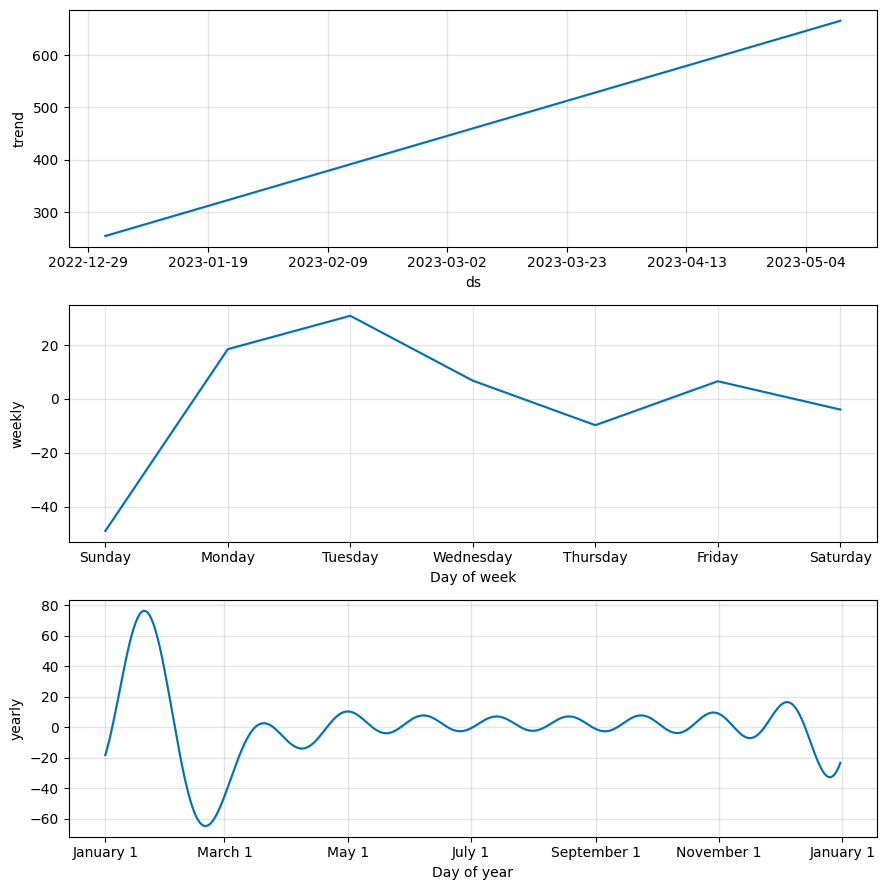

Visualizations complete.

Future Sales Predictions:
            ds        yhat  yhat_lower  yhat_upper
100 2023-04-11  590.494504  448.442012  719.931127
101 2023-04-12  570.194731  436.916608  704.229042
102 2023-04-13  557.670390  425.791589  682.224780
103 2023-04-14  578.179633  455.351178  711.804522
104 2023-04-15  572.042418  453.040597  702.044449
105 2023-04-16  531.491693  403.653438  657.736932
106 2023-04-17  603.677652  479.515206  728.865898
107 2023-04-18  620.834382  486.910078  755.147290
108 2023-04-19  601.588969  471.215484  737.990451
109 2023-04-20  589.944762  460.506462  726.400585
110 2023-04-21  611.140318  470.847853  742.936232
111 2023-04-22  605.480331  483.517363  737.481584
112 2023-04-23  565.187201  429.485055  696.549643
113 2023-04-24  637.405576  510.517627  766.276467
114 2023-04-25  654.369154  533.352052  792.509171
115 2023-04-26  634.709844  498.106264  762.915319
116 2023-04-27  622.440938  491.262523  749.569211
117 2023-04-28  642.815857  51

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os

# --- Configuration ---
DATA_FILE = 'sales_data.csv'  # Your dataset file name
DATE_COLUMN = 'Date'          # Name of your date column
SALES_COLUMN = 'Sales'        # Name of your sales column
FORECAST_PERIOD_DAYS = 30     # How many days into the future to predict

# --- 1. Dataset Connection and Loading ---
def load_data(file_path):
    """Loads data from a CSV file."""
    if not os.path.exists(file_path):
        print(f"Error: Dataset file '{file_path}' not found.")
        print("Please make sure the CSV file is in the same directory as this script, or provide the full path.")
        # Create a dummy CSV for demonstration if not found
        print("Creating a dummy 'sales_data.csv' for demonstration purposes.")
        dummy_data = {
            'Date': pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='D')),
            'Sales': np.random.randint(100, 500, size=100) + np.sin(np.arange(100)/10) * 50 + np.linspace(0, 200, 100)
        }
        dummy_df = pd.DataFrame(dummy_data)
        dummy_df.to_csv(file_path, index=False)
        print(f"Dummy file '{file_path}' created. Please replace it with your actual data.")
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data from '{file_path}'.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# --- 2. Data Preprocessing ---
def preprocess_data(df, date_col, sales_col):
    """
    Preprocesses the DataFrame for Prophet.
    Prophet requires columns named 'ds' (datestamp) and 'y' (series value).
    """
    if df is None:
        return None

    # Check if required columns exist
    if date_col not in df.columns:
        print(f"Error: Date column '{date_col}' not found in the dataset.")
        return None
    if sales_col not in df.columns:
        print(f"Error: Sales column '{sales_col}' not found in the dataset.")
        return None

    df_prophet = df[[date_col, sales_col]].copy()
    df_prophet.rename(columns={date_col: 'ds', sales_col: 'y'}, inplace=True)

    # Convert 'ds' to datetime objects
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

    # Sort by date
    df_prophet.sort_values(by='ds', inplace=True)

    # Handle missing values (simple imputation for sales)
    if df_prophet['y'].isnull().any():
        print("Warning: Missing values found in sales data. Filling with mean.")
        df_prophet['y'].fillna(df_prophet['y'].mean(), inplace=True)

    print("Data preprocessed successfully for Prophet.")
    return df_prophet

# --- 3. Model Training ---
def train_model(df_processed):
    """Trains the Prophet model."""
    if df_processed is None:
        return None

    print("Training Prophet model...")
    model = Prophet(
        growth='linear',  # or 'logistic' if sales saturate
        seasonality_mode='additive', # or 'multiplicative'
        weekly_seasonality=True,
        daily_seasonality=False, # Often not needed for sales data unless daily patterns are strong
        yearly_seasonality=True,
        changepoint_prior_scale=0.05 # Adjust this for more/less flexibility in trend
    )
    # Add holidays if you have a holiday dataset
    # holidays = pd.DataFrame({'holiday': 'christmas', 'ds': pd.to_datetime(['2024-12-25', '2025-12-25']), 'lower_window': -1, 'upper_window': 0})
    # model.add_country_holidays(country_name='US') # Example for US holidays
    # model.add_seasonality(name='quarterly', period=91.25, fourier_order=8) # Example for quarterly seasonality

    model.fit(df_processed)
    print("Model training complete.")
    return model

# --- 4. Prediction ---
def make_predictions(model, forecast_period_days):
    """Generates future predictions."""
    if model is None:
        return None

    print(f"Generating future dataframe for {forecast_period_days} days...")
    future = model.make_future_dataframe(periods=forecast_period_days)
    print("Making predictions...")
    forecast = model.predict(future)
    print("Predictions generated.")
    return forecast

# --- 5. Evaluation (Optional, on historical data) ---
def evaluate_model(df_processed, forecast):
    """Evaluates the model's performance on historical data."""
    if df_processed is None or forecast is None:
        return

    print("Evaluating model performance...")
    # Merge actual values with forecast for evaluation
    df_eval = pd.merge(df_processed, forecast[['ds', 'yhat']], on='ds', how='inner')

    y_true = df_eval['y']
    y_pred = df_eval['yhat']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Avoid division by zero for MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100 if (y_true != 0).any() else np.nan


    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    return mae, rmse, mape

# --- 6. Visualization ---
def visualize_results(model, forecast):
    """Visualizes the forecast."""
    if model is None or forecast is None:
        return

    print("Generating visualizations...")
    fig1 = model.plot(forecast)
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()

    fig2 = model.plot_components(forecast)
    plt.show()
    print("Visualizations complete.")

# --- 7. Save Results ---
def save_forecast(forecast, output_file='sales_forecast.csv'):
    """Saves the forecast to a CSV file."""
    if forecast is None:
        return
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(output_file, index=False)
    print(f"\nForecast saved to '{output_file}'")

# --- Main Execution Function ---
def run_sales_forecasting(data_file, date_col, sales_col, forecast_period_days):
    """Runs the complete sales forecasting process."""
    # 1. Load Data
    df = load_data(data_file)

    # 2. Preprocess Data
    df_processed = preprocess_data(df, date_col, sales_col)

    if df_processed is not None and not df_processed.empty:
        # 3. Train Model
        model = train_model(df_processed)

        if model:
            # 4. Make Predictions
            forecast = make_predictions(model, forecast_period_days)

            # 5. Evaluate Model (optional)
            evaluate_model(df_processed, forecast)

            # 6. Visualize Results
            visualize_results(model, forecast)

            # Display the last few predicted sales
            print("\nFuture Sales Predictions:")
            print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast_period_days))

            # 7. Save Results
            save_forecast(forecast)
    else:
        print("Could not proceed with prediction due to data loading or preprocessing issues.")

# --- Execute the main function ---
if __name__ == "__main__":
    run_sales_forecasting(DATA_FILE, DATE_COLUMN, SALES_COLUMN, FORECAST_PERIOD_DAYS)